In [1]:
# Cell 1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Cell 2
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
# Cell 3
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 64*14*14)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)


In [5]:
# Cell 4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
# Cell 5
num_epochs = 10
train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss/len(train_loader)
    train_acc = 100.*correct/total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    correct = 0
    total = 0
    running_loss_test = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss_test += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_loss = running_loss_test/len(test_loader)
    test_acc = 100.*correct/total
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch [1/10] Train Loss: 0.4122, Train Acc: 85.16% Test Loss: 0.2899, Test Acc: 89.36%
Epoch [2/10] Train Loss: 0.2669, Train Acc: 90.31% Test Loss: 0.2481, Test Acc: 90.94%
Epoch [3/10] Train Loss: 0.2173, Train Acc: 92.02% Test Loss: 0.2418, Test Acc: 91.23%
Epoch [4/10] Train Loss: 0.1827, Train Acc: 93.19% Test Loss: 0.2228, Test Acc: 92.11%
Epoch [5/10] Train Loss: 0.1549, Train Acc: 94.23% Test Loss: 0.2307, Test Acc: 91.87%
Epoch [6/10] Train Loss: 0.1341, Train Acc: 94.95% Test Loss: 0.2251, Test Acc: 92.51%
Epoch [7/10] Train Loss: 0.1158, Train Acc: 95.60% Test Loss: 0.2520, Test Acc: 92.67%
Epoch [8/10] Train Loss: 0.1005, Train Acc: 96.23% Test Loss: 0.2671, Test Acc: 91.94%
Epoch [9/10] Train Loss: 0.0911, Train Acc: 96.64% Test Loss: 0.2554, Test Acc: 92.63%
Epoch [10/10] Train Loss: 0.0817, Train Acc: 96.87% Test Loss: 0.2558, Test Acc: 92.89%


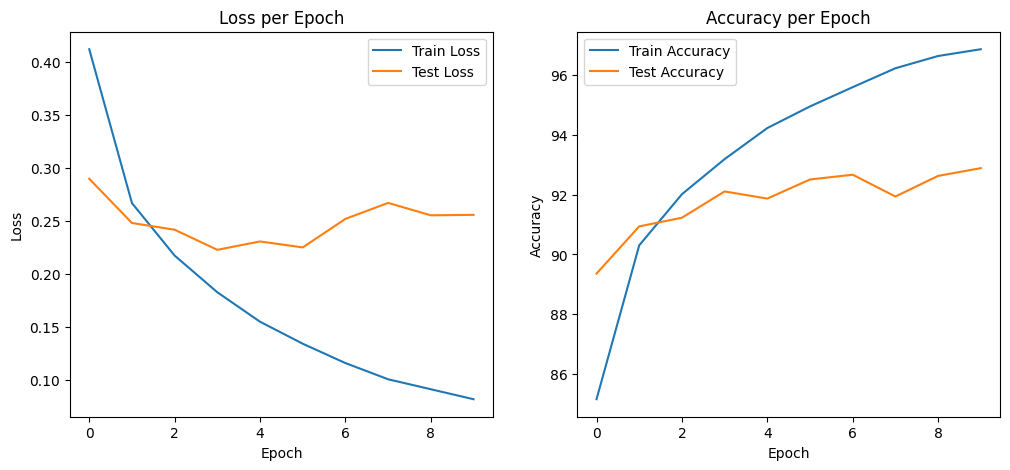

In [7]:
# Cell 6
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()


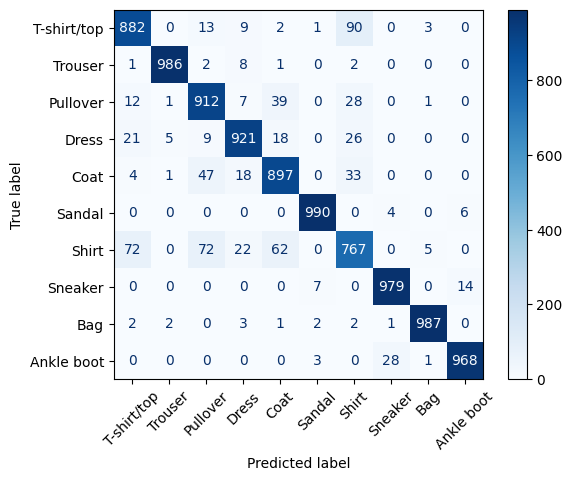

In [8]:
# Cell 7
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()


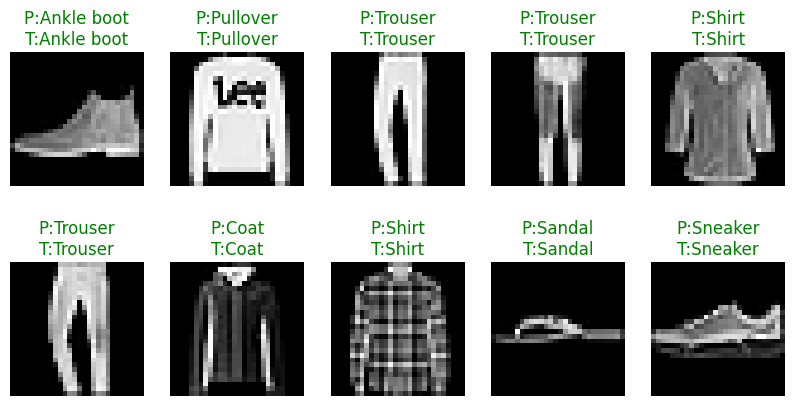

In [9]:
# Cell 8
fig = plt.figure(figsize=(10,5))
examples = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    for i in range(len(labels)):
        if examples >= 10:
            break
        ax = fig.add_subplot(2, 5, examples+1)
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f"P:{train_dataset.classes[preds[i]]}\nT:{train_dataset.classes[labels[i]]}",
                     color=('green' if preds[i]==labels[i] else 'red'))
        ax.axis('off')
        examples += 1
    if examples >= 10:
        break
plt.show()
